<a href="https://colab.research.google.com/github/sprerak48/Autonomous-tagging-using-Deep-Learning/blob/Prerak/AT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
print('Our pythn shared notebook we can code here')

Our pythn shared notebook we can code here


In [2]:
from google.colab import files
uploaded = files.upload()

Saving kaggle.json to kaggle.json


In [3]:
!pip install kaggle
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json


In [4]:
!kaggle datasets download -d stackoverflow/stacksample

 99% 1.13G/1.15G [00:13<00:00, 98.4MB/s]
100% 1.15G/1.15G [00:13<00:00, 88.2MB/s]


In [5]:
!unzip stacksample


Archive:  stacksample.zip
  inflating: Answers.csv             
  inflating: Questions.csv           
  inflating: Tags.csv                


In [0]:
import collections
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
%matplotlib inline
import math

questions = pd.read_csv("Questions.csv", encoding='latin1')
answers = pd.read_csv("Answers.csv", encoding='latin1')
tags = pd.read_csv("Tags.csv", encoding='latin1')

In [0]:
ans_per_question = collections.Counter(answers['ParentId'])
answerid,noAnswers= zip(*ans_per_question.most_common())
text = "Avegrage number of answers per question ",np.mean(noAnswers)

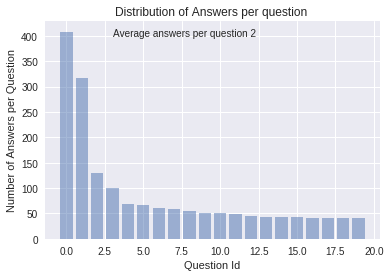

In [11]:
N=20
plt.bar(range(N), noAnswers[:N], align='center', alpha=0.5)
#plt.xticks(y_pos, objects)

plt.ylabel('Number of Answers per Question')
plt.xlabel('Question Id')
plt.title('Distribution of Answers per question ')
plt.text(3,400,"Average answers per question "+str(math.ceil((np.mean(noAnswers)))))

plt.show()

In [12]:
print("Top 2 Questions with maximum number of answers \n")
qid = answerid[:2] 

for b,id in zip(questions['Body'],questions['Id']):
    if id in qid:
        #print(id)
        print(b)
        print("................")

Top 2 Questions with maximum number of answers 

<p>This is a <a href="http://stackoverflow.com/questions/tagged/polls">poll</a> asking the Stackoverflow community what <strong>non-programming</strong> books they would recommend to fellow programmers.</p>

<h3>Please read the following before posting:</h3>

<ul>
<li><p>Please post only <em>ONE BOOK PER ANSWER</em>.</p></li>
<li><p>Please <em>search for your recommendation on this page before posting</em> (there are over NINE PAGES so it is advisable to check them all). Many books have already been suggested and we want to avoid duplicates. If you find your recommendation is already present, vote it up or add some commentary.</p></li>
<li><p><strong>Please elaborate</strong> <em>on <strong>why</strong> you think a given book is worth reading</em> <strong><em>from a programmer's perspective.</em></strong></p></li>
</ul>

<p>Note: <a href="http://stackoverflow.com/questions/31274/best-non-development-book-for-software-developers">this art

In [0]:
def plot_tags(tagCount):
    
    x,y = zip(*tagCount)

    colormap = plt.cm.gist_ncar #nipy_spectral, Set1,Paired  
    colors = [colormap(i) for i in np.linspace(0, 0.8,50)]   

    area = [i/4000 for i in list(y)]   # 0 to 15 point radiuses
    plt.figure(figsize=(9,8))
    plt.ylabel("Number of question associations")
    for i in range(len(y)):
        plt.plot(i,y[i], marker='o', linestyle='',ms=area[i],label=x[i])

    plt.legend(numpoints=1)
    plt.show()

[('javascript', 124155), ('java', 115212), ('c#', 101186), ('php', 98808), ('android', 90659), ('jquery', 78542), ('python', 64601), ('html', 58976), ('c++', 47591), ('ios', 47009)]


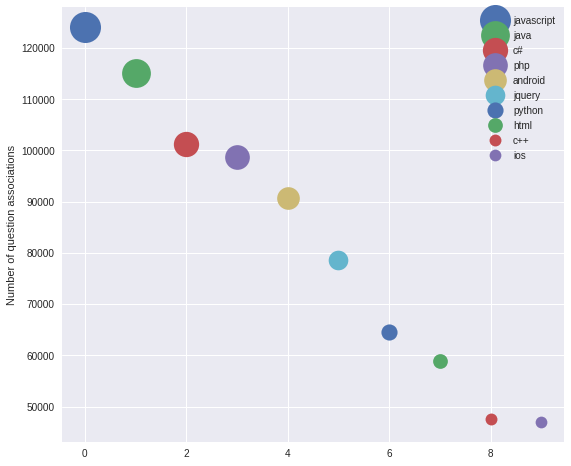

In [14]:
tagCount =  collections.Counter(list(tags['Tag'])).most_common(10)
print(tagCount)
plot_tags(tagCount)

In [15]:
topQuestions =list(zip(questions["Id"],questions["Score"],questions["Title"]))
topQuestions.sort(key=lambda x: x[1],reverse=True)
for id,s,t in topQuestions[:20]:
    #print("Question id:",id)
    print("Score :",s)
    print("Question Title\t:",t,'\n') 

Score : 5190
Question Title	: How to undo 'git add' before commit? 

Score : 3613
Question Title	: Is Java "pass-by-reference" or "pass-by-value"? 

Score : 2537
Question Title	: Regular expression to match line that doesn't contain a word? 

Score : 2399
Question Title	: Make an existing Git branch track a remote branch? 

Score : 2363
Question Title	: Why does Google prepend while(1); to their JSON responses? 

Score : 1760
Question Title	: How to check if a string contains a specific word in PHP? 

Score : 1759
Question Title	: How do I empty an array in JavaScript? 

Score : 1716
Question Title	: How to find all files containing specific text on Linux? 

Score : 1620
Question Title	: Loop through an array in JavaScript 

Score : 1614
Question Title	: How do you disable browser Autocomplete on web form field / input tag? 

Score : 1613
Question Title	: How do I give text or an image a transparent background using CSS? 

Score : 1567
Question Title	: How can I determine the URL that 

In [30]:
#IDENTIFYING CLUSTERS OF SIMILAR QUESTIONS
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import nltk
nltk.download('punkt')
nltk.download('wordnet')
from multiprocessing import Pool
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
import re
from itertools import chain
from collections import Counter
import pickle
import scipy.io as scio
from sklearn.decomposition import TruncatedSVD
import scipy.spatial.distance as distance
import scipy.cluster.hierarchy as hierarchy
from scipy.stats import pearsonr

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


In [0]:
dat = pd.read_csv("Questions.csv", encoding='latin1')
dat['Title'].fillna("None", inplace=True)
dat['Score'].fillna(0, inplace=True)

In [18]:
selected_ids = np.random.choice(range(dat.shape[0]), 20000, replace=False)
sample = dat.loc[selected_ids, :]
sample.shape

(20000, 7)

In [19]:
sample.head()


,Id,OwnerUserId,CreationDate,ClosedDate,Score,Title,Body
784469,26507960,1971279.0,2014-10-22T12:55:56Z,NaN,0,Callback for backbone child view?,<p>I have been all over google looking for thi...
191262,7326910,162045.0,2011-09-06T22:29:08Z,2013-11-11T02:56:00Z,5,Tools for protocol simulation,<p>My software development team has recently f...
1244409,39673690,6501155.0,2016-09-24T07:20:28Z,NaN,1,HTML/CSS Progess Bar shows on browser but does...,<p>Im helping a friend create a resume and wan...
915553,30558920,4599151.0,2015-05-31T15:04:13Z,NaN,0,How to use Thread.sleep() in this example in a...,<p>I have some example code on main thread:</p...
608088,20952790,1542555.0,2014-01-06T15:02:44Z,NaN,-1,Umlauts not working by exporting a CSV-File,<p>i have a problem by exporting data with uml...


In [0]:
def purify_string(html):
    return re.sub('(\r\n)+|\r+|\n+', " ", re.sub('<[^<]+?>', '', html))


In [22]:
corpus = sample.ix[:, 'Body'].apply(purify_string)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  """Entry point for launching an IPython kernel.


In [0]:
def combine_title_body(tnb):
    return tnb[0] + " " + tnb[1]

In [0]:
p = Pool(8)
combined_corpus = p.map(combine_title_body, zip(dat['Title'], corpus))
p.close()

In [26]:
combined_corpus[:2]


['SQLStatement.execute() - multiple queries in one statement I have been all over google looking for this, I can\'t come up with a clear solution. I have a chatView that renders a collectionView of messages (messagesView). I need to wait until all the messages are fetched and rendered before I can run a function to scroll to the bottom of the list of messages.  Here is a stripped up version of my code. var socket             = io.connect(),        Marionette         = require(\'backbone.marionette\'),     MessagesCollection = require(\'../collections/messages\'),     MessagesView       = require(\'./messages\'),     MessageModel       = require(\'../models/message\'); module.exports = ChatView = Marionette.CompositeView.extend({      className: \'chat col-sm-9\',     template: require(\'../../templates/chat.hbs\'),     events: {         \'focusin input.message\': \'userTyping\',         \'focusout input.message\': \'userNotTyping\',         \'submit #chat-form\': \'sendMessage\'     },

In [0]:
lem = WordNetLemmatizer()
def cond_tokenize(t):
    if t is None:
        return []
    else:
        return [lem.lemmatize(w.lower()) for w in word_tokenize(t)]

p = Pool(8)
tokens = list(p.imap(cond_tokenize, combined_corpus))
p.close()

In [33]:
pure_tokens = [" ".join(sent) for sent in tokens]
print(tokens[0]) # this are the single lemmatized and stemmed tokens
print(pure_tokens[0]) # these are the tokens combined in original form

['sqlstatement.execute', '(', ')', '-', 'multiple', 'query', 'in', 'one', 'statement', 'i', 'have', 'been', 'all', 'over', 'google', 'looking', 'for', 'this', ',', 'i', 'ca', "n't", 'come', 'up', 'with', 'a', 'clear', 'solution', '.', 'i', 'have', 'a', 'chatview', 'that', 'render', 'a', 'collectionview', 'of', 'message', '(', 'messagesview', ')', '.', 'i', 'need', 'to', 'wait', 'until', 'all', 'the', 'message', 'are', 'fetched', 'and', 'rendered', 'before', 'i', 'can', 'run', 'a', 'function', 'to', 'scroll', 'to', 'the', 'bottom', 'of', 'the', 'list', 'of', 'message', '.', 'here', 'is', 'a', 'stripped', 'up', 'version', 'of', 'my', 'code', '.', 'var', 'socket', '=', 'io.connect', '(', ')', ',', 'marionette', '=', 'require', '(', "'backbone.marionette", "'", ')', ',', 'messagescollection', '=', 'require', '(', "'../collections/messages", "'", ')', ',', 'messagesview', '=', 'require', '(', "'./messages", "'", ')', ',', 'messagemodel', '=', 'require', '(', "'../models/message", "'", ')', 

In [0]:
vectorizer = TfidfVectorizer(min_df=1, max_features=2000, stop_words='english', ngram_range=[1, 1], sublinear_tf=True)
tfidf = vectorizer.fit_transform(pure_tokens) # this is the vector matrix of the tfidf

In [0]:
idfs = pd.DataFrame([[v, k] for k, v in vectorizer.vocabulary_.items()], columns=['id', 'word']).sort_values('id')
idfs['idf'] = vectorizer.idf_

In [37]:
print(idfs.sort_values('idf').head(20))

       id      word       idf
94   1867     using  1.999179
20    394      code  2.025458
235   840        gt  2.055315
77   1091        lt  2.125674
99   1043      like  2.193742
399  1916      want  2.290671
47   1193       new  2.342710
302  1858       use  2.361847
130   726      file  2.401458
221  1947      work  2.451630
174   592       doe  2.454623
304   378     class  2.461715
342  1921       way  2.503103
254   662     error  2.526987
53    501      data  2.538564
16    782  function  2.557607
421  1881     value  2.576053
12   1188      need  2.612994
328  1502    return  2.623587
210  1369   problem  2.662098


In [0]:
tsvd = TruncatedSVD(n_components=500) # TODO this n_components=500 is a hyperparameter, look into it
transformed = tsvd.fit_transform(tfidf)

In [39]:
np.sum(tsvd.explained_variance_ratio_)


0.583466922257338

In [40]:
transformed.shape

(20000, 500)

In [0]:
D = distance.pdist(transformed, 'cosine')

In [44]:
L = hierarchy.linkage(D)
np.mean(D)

0.9342161160190237

In [0]:
cls = hierarchy.fcluster(L, 0.71, criterion='inconsistent')


In [46]:
df_cls = pd.DataFrame({'Pos': selected_ids, 'Cluster': cls})
cnts = df_cls.groupby('Cluster').size().sort_values(ascending=False)
cnts.sort_values(ascending=False).head()

Cluster
3718    38
1945    28
3624    19
1171    18
1324    17
dtype: int64

In [47]:
bc = pd.concat([sample, df_cls.set_index('Pos')], axis=1)
bc.head()

,Id,OwnerUserId,CreationDate,ClosedDate,Score,Title,Body,Cluster
Pos,,,,,,,,
784469,26507960,1971279.0,2014-10-22T12:55:56Z,NaN,0,Callback for backbone child view?,<p>I have been all over google looking for thi...,9440
191262,7326910,162045.0,2011-09-06T22:29:08Z,2013-11-11T02:56:00Z,5,Tools for protocol simulation,<p>My software development team has recently f...,15105
1244409,39673690,6501155.0,2016-09-24T07:20:28Z,NaN,1,HTML/CSS Progess Bar shows on browser but does...,<p>Im helping a friend create a resume and wan...,4614
915553,30558920,4599151.0,2015-05-31T15:04:13Z,NaN,0,How to use Thread.sleep() in this example in a...,<p>I have some example code on main thread:</p...,7014
608088,20952790,1542555.0,2014-01-06T15:02:44Z,NaN,-1,Umlauts not working by exporting a CSV-File,<p>i have a problem by exporting data with uml...,2804


In [0]:
stats = bc.groupby('Cluster')['Score'].describe().unstack()


In [49]:
stats.sort_values(ascending=False).head(10)

      Cluster
min   13128      544.0
75%   13128      544.0
mean  13128      544.0
25%   13128      544.0
50%   13128      544.0
max   13128      544.0
      509        409.0
min   8670       396.0
50%   8670       396.0
25%   8670       396.0
dtype: float64

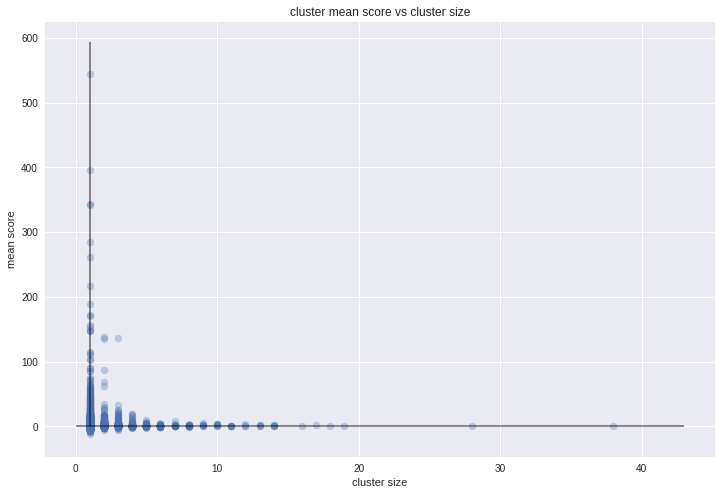

In [50]:
plt.figure(figsize=(12, 8))
plt.hlines([0], xmin=0, xmax=np.max(stats['count']) + 5, alpha=0.5)
plt.vlines([1], ymin=0, ymax=np.max(stats['mean']) + 50, alpha=0.5)
plt.scatter(stats['count'], stats['mean'], alpha=0.3)
plt.title("cluster mean score vs cluster size")
plt.xlabel("cluster size")
plt.ylabel("mean score")
plt.show()

In [51]:
bc.loc[bc['Cluster'] == cnts.index[0]][['Score', 'Title', 'Body']]


,Score,Title,Body
Pos,,,
892629,0,How to arrange table td using rowspan,<p>I have to arrange table cells as shown in t...
63830,3,Creating the same event for 2 different elemen...,"<p>Hey guys,\nI'd like to create a toggle even..."
962971,1,Webdriver how replace dynamic locator to use P...,<p>Here is html code:</p>\n\n<pre><code>&lt;ta...
162911,0,include button into .cs file,<p>I'm trying to read a text file containing t...
200835,1,jquery + css - hover with parameter,"<pre><code>&lt;table id=""tab""&gt;\n &lt;tr ..."
265742,0,Can I exclude a div tag/tr tag get update insi...,<p>Below is not a valid code( I just show some...
850020,1,table Alignment issue - html to pdf conversion...,<p>I am facing issues in table alignment when ...
409782,0,access variables inside two ajax functions,<p>can i achieve this even more simpler way ??...
869549,0,Getting text and sending it to a php function ...,<p>I have a php function which displays all th...


In [52]:
bc.loc[bc['Cluster'] == cnts.index[1]][['Score', 'Title', 'Body']]


,Score,Title,Body
Pos,,,
905481,0,how to extract multiple cells from different r...,<p>Currently I need to extract value from diff...
1135214,1,Loop through range and append values based on ...,"<p>Search the web and SO, but couldn't find an..."
860926,0,Excel active sheet row count reflect previousl...,<p>I have imported a csv file to sheet(4). I w...
1205404,0,Creating a txt file from Excel spreadsheet,<p>I am using the below code to create a .txt ...
1016298,1,Populating TreeView with column header and sub...,<p>I am new to tree view control and would lik...
1220602,0,How to use vlookup to find values in a workshe...,<p>Im trying to pull the unit and price from a...
1078420,1,Dynamic For Loops in VBA,"<p>Being quite new at VBA, I would appreciate ..."
998583,0,Compile error 'named argument not found',<p>Excel 2007</p>\n\n<pre><code>Sub Filtered_d...
715637,0,Use a loop to delete data in a table range fro...,<p>I'd like to setup a macro to remove data fr...


In [53]:
bc.loc[bc['Cluster'] == cnts.index[2]][['Score', 'Title', 'Body']]


,Score,Title,Body
Pos,,,
638470,0,Event after selecting item from checkbox multi...,<p>I have to display second select list if par...
652267,-1,Jquery Ajax not able to overwrite the span class,<p>I am getting the value in the script which ...
1200435,2,Dynamically append dropdown's value text to an...,"<pre><code>&lt;select id=""mg_sport_game_id1""&g..."
416688,0,dynamic dropdown to checkbox,<p>I would like to convert my current code to ...
1184502,0,How to display a select only when other select...,<p>I have 4 selects on a page and only the fir...
721535,0,I am trying to add a text area based on Other ...,<p>I am trying to add a textarea based on the ...
177165,0,Populate DropDown and Get Selected Value From ...,<p>I have the code to select the values from a...
546443,0,Need function to run on selecting an option in...,<p>Hi I know this has probably been asked befo...
1105621,0,option list using array - php,<p><strong>Data from database are already okay...
